In [1]:
import os
import torch

from xlm.utils import AttrDict
from xlm.data.dictionary import Dictionary, BOS_WORD, EOS_WORD, PAD_WORD, UNK_WORD, MASK_WORD
from xlm.model.transformer import TransformerModel

FAISS not available. Switching to standard nearest neighbors search implementation.


In [2]:
model_path = 'mlm_100_1280.pth'
reloaded = torch.load(model_path, map_location=torch.device('cpu'))
params = AttrDict(reloaded['params'])
print("Supported languages: %s" % ", ".join(params.lang2id.keys()))

Supported languages: af, als, am, an, ang, ar, arz, ast, az, bar, be, bg, bn, br, bs, ca, ceb, ckb, cs, cy, da, de, el, en, eo, es, et, eu, fa, fi, fr, fy, ga, gan, gl, gu, he, hi, hr, hu, hy, ia, id, is, it, ja, jv, ka, kk, kn, ko, ku, la, lb, lt, lv, mk, ml, mn, mr, ms, my, nds, ne, nl, nn, no, oc, pl, pt, ro, ru, scn, sco, sh, si, simple, sk, sl, sq, sr, sv, sw, ta, te, th, tl, tr, tt, uk, ur, uz, vi, war, wuu, yi, zh, zh_classical, zh_min_nan, zh_yue


In [3]:
dico = Dictionary(reloaded['dico_id2word'], reloaded['dico_word2id'], reloaded['dico_counts'])
params.n_words = len(dico)
params.bos_index = dico.index(BOS_WORD)
params.eos_index = dico.index(EOS_WORD)
params.pad_index = dico.index(PAD_WORD)
params.unk_index = dico.index(UNK_WORD)
params.mask_index = dico.index(MASK_WORD)

# build model / reload weights
model = TransformerModel(params, dico, True, True)
model.eval()
model.load_state_dict(reloaded['model'])

<All keys matched successfully>

In [4]:
mk = model.embeddings.weight[dico.index('мајка')].detach().numpy() 
ru = model.embeddings.weight[dico.index('мама')].detach().numpy() 
uk = model.embeddings.weight[dico.index('мати')].detach().numpy() 
bg = model.embeddings.weight[dico.index('майка')].detach().numpy() 
sl = model.embeddings.weight[dico.index('matka')].detach().numpy() 

In [5]:
slavic_group = []
slavic_group.append(mk)
slavic_group.append(ru)
slavic_group.append(uk)
slavic_group.append(bg)
slavic_group.append(sl)

In [6]:
slavic_group

[array([ 0.02212524, -0.02745056,  0.00708008, ..., -0.01311493,
        -0.03070068, -0.02415466], dtype=float32),
 array([ 0.00144672, -0.03787231,  0.09863281, ...,  0.00145912,
        -0.06896973, -0.00798035], dtype=float32),
 array([ 0.00824738, -0.01945496,  0.0125351 , ...,  0.02302551,
        -0.05166626,  0.02682495], dtype=float32),
 array([ 0.02934265, -0.04785156,  0.02790833, ..., -0.02983093,
         0.00952148, -0.04238892], dtype=float32),
 array([ 0.04559326,  0.02922058,  0.07183838, ..., -0.05783081,
         0.01596069, -0.05136108], dtype=float32)]

In [7]:
slavic = {}
slavic['sl'] = sl
slavic['ru'] = ru
slavic['mk'] = mk
slavic['uk'] = uk
slavic['bg'] = bg

In [8]:
slavic

{'sl': array([ 0.04559326,  0.02922058,  0.07183838, ..., -0.05783081,
         0.01596069, -0.05136108], dtype=float32),
 'ru': array([ 0.00144672, -0.03787231,  0.09863281, ...,  0.00145912,
        -0.06896973, -0.00798035], dtype=float32),
 'mk': array([ 0.02212524, -0.02745056,  0.00708008, ..., -0.01311493,
        -0.03070068, -0.02415466], dtype=float32),
 'uk': array([ 0.00824738, -0.01945496,  0.0125351 , ...,  0.02302551,
        -0.05166626,  0.02682495], dtype=float32),
 'bg': array([ 0.02934265, -0.04785156,  0.02790833, ..., -0.02983093,
         0.00952148, -0.04238892], dtype=float32)}

In [10]:
roman = {}
roman['pt'] = model.embeddings.weight[dico.index('mãe')].detach().numpy()
roman['fr'] = model.embeddings.weight[dico.index('mère')].detach().numpy()
roman['it'] = model.embeddings.weight[dico.index('madre')].detach().numpy()
roman['es'] = model.embeddings.weight[dico.index('madre')].detach().numpy()
roman['rm'] = model.embeddings.weight[dico.index('mamă')].detach().numpy()

In [32]:
roman

{'pt': array([-0.00211143,  0.03900146,  0.01464081, ..., -0.0350647 ,
        -0.00086069, -0.00820923], dtype=float32),
 'fr': array([-0.01029968,  0.05157471,  0.02561951, ..., -0.00738907,
         0.03851318, -0.03323364], dtype=float32),
 'it': array([-0.00174713, -0.00039053,  0.07434082, ..., -0.03897095,
         0.01820374, -0.06933594], dtype=float32),
 'es': array([-0.00174713, -0.00039053,  0.07434082, ..., -0.03897095,
         0.01820374, -0.06933594], dtype=float32),
 'rm': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32)}

In [11]:
roman_group = []
for k in roman:
    roman_group.append(roman[k])

In [34]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([slavic_group,roman_group]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.41


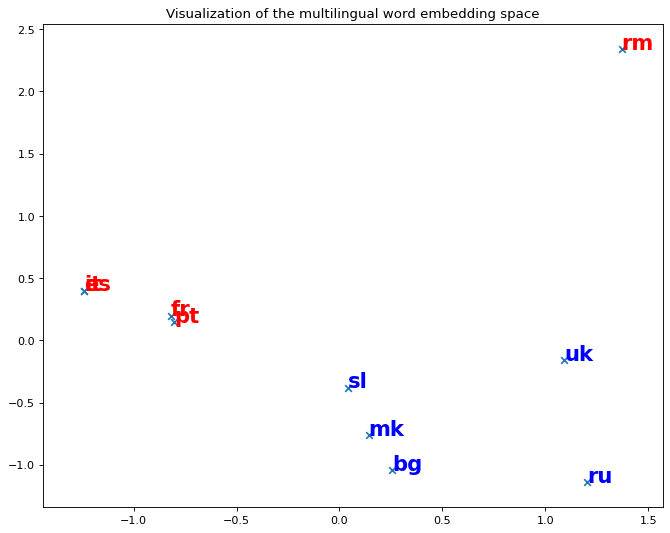

In [35]:
import matplotlib.pyplot as plt
Y = []
langs = []

for k in slavic:
    Y.append(slavic[k])
    langs. append(k)
# for k in german:
#     Y.append(german[k])
#     langs. append(k)

for k in roman:
    Y.append(roman[k])
    langs. append(k)


# find tsne coords for 2 dimensions
Y = pca.transform(Y)
x_coords = Y[:, 0]
y_coords = Y[:, 1]

    # display scatter plot
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(x_coords, y_coords, marker='x')
for k, (label, x, y) in enumerate(zip(langs, x_coords, y_coords)):
    if k in [0,4]:
        color = 'blue'
    if k in [5,9]:
        color = 'red'
#     if k in [10,14]:
#         color = 'm'
    #color = 'blue' if k<len(slavic) else color = 'red'  # src words in blue / tgt words in red
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                    color=color, weight='bold')


plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
plt.title('Visualization of the multilingual word embedding space')

plt.show()

In [50]:
baltic = {}
baltic['lv'] = model.embeddings.weight[dico.index('māte')].detach().numpy()
baltic['lt'] = model.embeddings.weight[dico.index('motina')].detach().numpy()
keltic = {}
keltic['kr'] = model.embeddings.weight[dico.index('manman')].detach().numpy()
keltic['ir'] = model.embeddings.weight[dico.index('Máthair')].detach().numpy()
keltic['vl'] = model.embeddings.weight[dico.index('mam')].detach().numpy()
baltic_group = []
for k in baltic:
    baltic_group.append(baltic[k])
keltic_group = []
for k in keltic:
    keltic_group.append(keltic[k])

In [51]:
baltic

{'lv': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'lt': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32)}

In [46]:
keltic_group

[array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 array([ 0.03421021, -0.00427628,  0.03323364, ..., -0.04333496,
        -0.01701355, -0.03108215], dtype=float32)]

In [52]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack(keltic_group))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 1.00


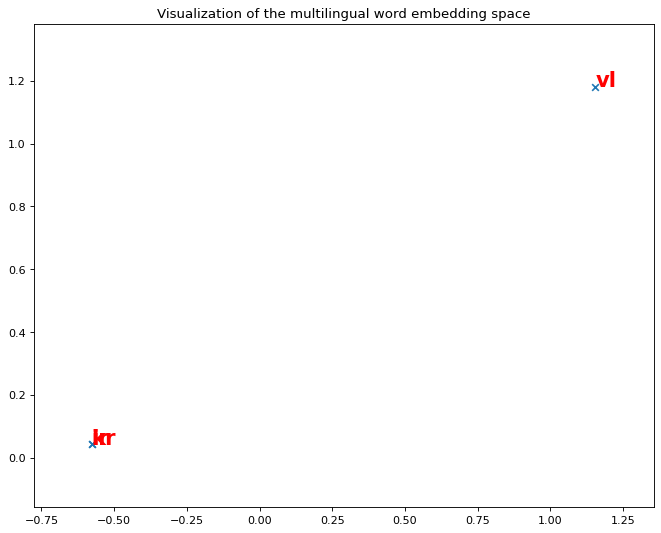

In [54]:
import matplotlib.pyplot as plt
Y = []
langs = []

for k in keltic:
    Y.append(keltic[k])
    langs. append(k)
# for k in baltic:
#     Y.append(baltic[k])
#     langs. append(k)


# find tsne coords for 2 dimensions
Y = pca.transform(Y)
x_coords = Y[:, 0]
y_coords = Y[:, 1]

    # display scatter plot
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(x_coords, y_coords, marker='x')
for k, (label, x, y) in enumerate(zip(langs, x_coords, y_coords)):
#     if k in [0,1]:
#         color = 'blue'
#     if k in [2,3]:
#         color = 'red'
#     if k in [10,14]:
#         color = 'm'
    #color = 'blue' if k<len(slavic) else color = 'red'  # src words in blue / tgt words in red
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                    color=color, weight='bold')


plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
plt.title('Visualization of the multilingual word embedding space')

plt.show()

In [56]:
german = {}
german['en'] = model.embeddings.weight[dico.index('mother')].detach().numpy()
german['de'] = model.embeddings.weight[dico.index('mutter')].detach().numpy()
german['da'] = model.embeddings.weight[dico.index('mor')].detach().numpy()
german['is'] = model.embeddings.weight[dico.index('móður')].detach().numpy()
german['nr'] = model.embeddings.weight[dico.index('moeder')].detach().numpy()
german_group = []
for k in german:
    german_group.append(german[k])

In [57]:
german

{'en': array([ 0.06585693,  0.00372696,  0.00466919, ..., -0.01594543,
         0.04299927, -0.03610229], dtype=float32),
 'de': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'da': array([ 0.00802612, -0.02618408, -0.01789856, ...,  0.01365662,
         0.04144287, -0.01207733], dtype=float32),
 'is': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'nr': array([ 0.04269409, -0.04165649,  0.0585022 , ..., -0.01986694,
         0.00898743, -0.01399231], dtype=float32)}

In [63]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([german_group,slavic_group,roman_group]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.43


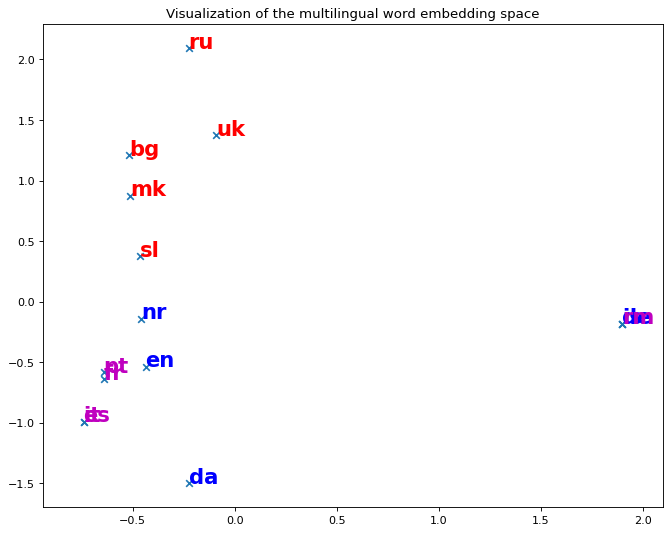

In [65]:
import matplotlib.pyplot as plt
Y = []
langs = []

for k in german:
    Y.append(german[k])
    langs. append(k)
for k in slavic:
    Y.append(slavic[k])
    langs. append(k)
for k in roman:
    Y.append(roman[k])
    langs. append(k)
# for k in baltic:
#     Y.append(baltic[k])
#     langs. append(k)


# find tsne coords for 2 dimensions
Y = pca.transform(Y)
x_coords = Y[:, 0]
y_coords = Y[:, 1]

    # display scatter plot
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(x_coords, y_coords, marker='x')
for k, (label, x, y) in enumerate(zip(langs, x_coords, y_coords)):
    if k in [0,4]:
        color = 'blue'
    if k in [5,9]:
        color = 'red'
    if k in [10,14]:
        color = 'm'
    #color = 'blue' if k<len(slavic) else color = 'red'  # src words in blue / tgt words in red
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                    color=color, weight='bold')


plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
plt.title('Visualization of the multilingual word embedding space')

plt.show()

In [72]:
soviet = {}
soviet['ru']=model.embeddings.weight[dico.index('самовар')].detach().numpy()
soviet['en']=model.embeddings.weight[dico.index('samovar')].detach().numpy()
soviet['fr']=model.embeddings.weight[dico.index('samovar')].detach().numpy()
soviet['de']=model.embeddings.weight[dico.index('Samowar')].detach().numpy()
soviet['uk']=model.embeddings.weight[dico.index('самовар')].detach().numpy()
soviet['mk']=model.embeddings.weight[dico.index('самовар')].detach().numpy()
soviet['af']=model.embeddings.weight[dico.index('samowar')].detach().numpy()

In [73]:
soviet_group = []
for k in soviet:
    soviet_group.append(soviet[k])

In [74]:
soviet

{'ru': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'en': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'fr': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'de': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'uk': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'mk': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32),
 'af': array([-0.00756073, -0.01541138,  0.01435852, ...,  0.02960205,
        -0.00991058, -0.02607727], dtype=float32)}